In [32]:
import pandas as pd
import numpy as np
from sklearn.linear_model import Lasso
from sklearn.ensemble import GradientBoostingRegressor
from keras.models import Sequential
from keras.layers import GRU, Dense
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# Đọc dữ liệu
df = pd.read_csv('/content/sample_data/NOK.csv')
#df = pd.read_csv('AAPL.csv', header=0, parse_dates=[0], index_col=0)
df = df[['Close']].dropna().reset_index(drop=True)

df.head()


,Close
0,6.04
1,6.03
2,5.94
3,5.87
4,5.78


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [53]:
# Chia tập train-test
train_size = int(0.9 * len(df))
test_size = len(df) - train_size
train_data, test_data = df.iloc[:train_size], df.iloc[train_size:]

In [54]:
# Scaling data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df)

# Function to create dataset for model
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 1
X_train, Y_train = create_dataset(scaled_data[:train_size], look_back)
X_test, Y_test = create_dataset(scaled_data[train_size:], look_back)

# Reshape input to be [samples, time steps, features] for GRU
X_train_gru = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test_gru = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))


In [55]:
# Lasso model
lasso = Lasso(alpha=0.01)
lasso.fit(X_train, Y_train)


Lasso(alpha=0.01)

In [56]:
# GRU model
gru_model = Sequential()
gru_model.add(GRU(units=50, return_sequences=True, input_shape=(1, look_back)))
gru_model.add(GRU(units=50))
gru_model.add(Dense(1))
gru_model.compile(loss='mean_squared_error', optimizer='adam')
gru_model.fit(X_train_gru, Y_train, epochs=100, batch_size=1, verbose=2)


Epoch 1/100
1130/1130 - 6s - loss: 0.0076 - 6s/epoch - 6ms/step
Epoch 2/100
1130/1130 - 3s - loss: 0.0015 - 3s/epoch - 2ms/step
Epoch 3/100
1130/1130 - 3s - loss: 0.0016 - 3s/epoch - 3ms/step
Epoch 4/100
1130/1130 - 4s - loss: 0.0016 - 4s/epoch - 3ms/step
Epoch 5/100
1130/1130 - 3s - loss: 0.0015 - 3s/epoch - 2ms/step
Epoch 6/100
1130/1130 - 3s - loss: 0.0015 - 3s/epoch - 3ms/step
Epoch 7/100
1130/1130 - 3s - loss: 0.0015 - 3s/epoch - 3ms/step
Epoch 8/100
1130/1130 - 4s - loss: 0.0015 - 4s/epoch - 3ms/step
Epoch 9/100
1130/1130 - 3s - loss: 0.0014 - 3s/epoch - 3ms/step
Epoch 10/100
1130/1130 - 3s - loss: 0.0014 - 3s/epoch - 2ms/step
Epoch 11/100
1130/1130 - 3s - loss: 0.0014 - 3s/epoch - 3ms/step
Epoch 12/100
1130/1130 - 3s - loss: 0.0014 - 3s/epoch - 3ms/step
Epoch 13/100
1130/1130 - 3s - loss: 0.0014 - 3s/epoch - 3ms/step
Epoch 14/100
1130/1130 - 3s - loss: 0.0014 - 3s/epoch - 2ms/step
Epoch 15/100
1130/1130 - 3s - loss: 0.0014 - 3s/epoch - 2ms/step
Epoch 16/100
1130/1130 - 3s - loss

In [57]:
# Gộp các dự đoán từ LSR và GRU
X_meta_train = np.column_stack((lasso.predict(X_train), gru_model.predict(X_train_gru).flatten()))
X_meta_test = np.column_stack((lasso.predict(X_test), gru_model.predict(X_test_gru).flatten()))

4/4 [==============================] - 0s 3ms/step


In [58]:
# Huấn luyện meta-learner
from sklearn.linear_model import LinearRegression
meta_model = LinearRegression()
meta_model.fit(X_meta_train, Y_train)

# Sử dụng meta-learner để dự đoán
ensemble_pred = meta_model.predict(X_meta_test)
ensemble_pred = scaler.inverse_transform(ensemble_pred.reshape(-1, 1))

In [59]:
future_steps = 30  # Định nghĩa số ngày dự đoán tương lai

# Dự đoán cho 30 ngày tiếp theo
ensemble_future_pred = []
last_window = scaled_data[-look_back:]  # Cập nhật last_window cho bước thời gian cuối cùng của dữ liệu

for i in range(future_steps):
    # Chuẩn bị dữ liệu cho mỗi bước thời gian trong tương lai
    last_window_gru = np.reshape(last_window, (1, 1, look_back))
    lasso_future_pred = lasso.predict(last_window)
    gru_future_pred = gru_model.predict(last_window_gru).flatten()
    X_meta_future = np.column_stack((lasso_future_pred, gru_future_pred))

    # Dự đoán sử dụng meta-learner
    future_pred = meta_model.predict(X_meta_future)
    ensemble_future_pred.append(future_pred[0])

    # Cập nhật last_window cho bước tiếp theo
    last_window = np.append(last_window[1:], future_pred)[np.newaxis]

ensemble_future_pred = scaler.inverse_transform(np.array(ensemble_future_pred).reshape(-1, 1))


1/1 [==============================] - 0s 20ms/step


In [60]:
# Adjusting index for plotting
last_index = df.index[-1]
future_index = range(last_index + 1, last_index + future_steps + 1)

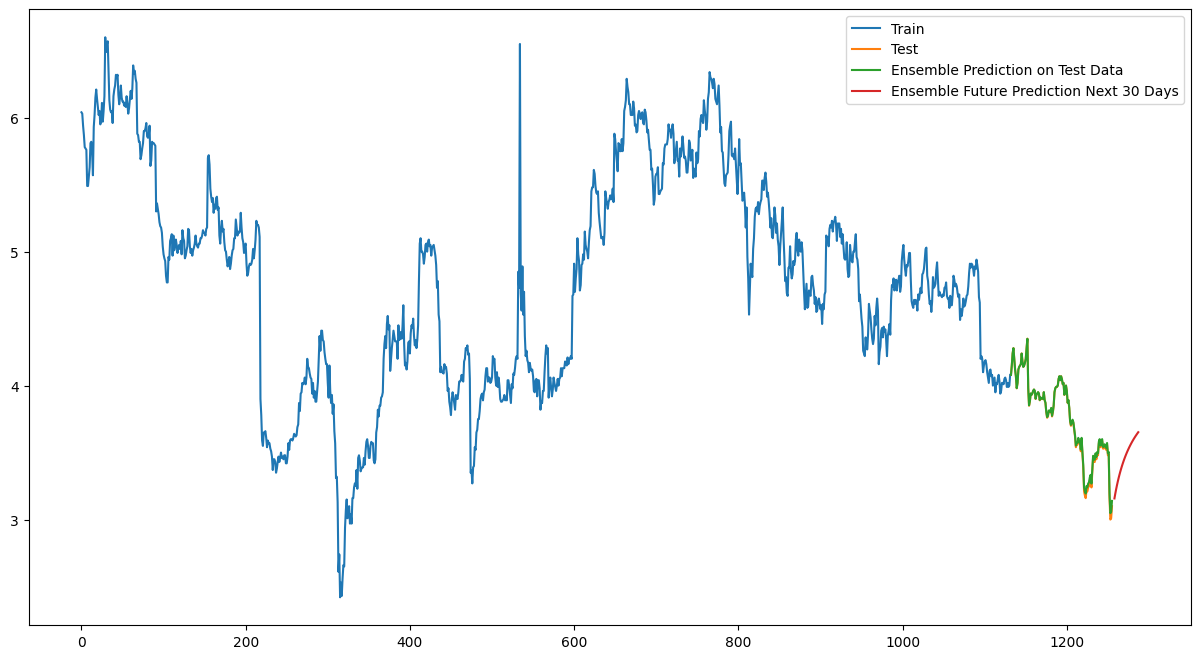

In [61]:
# Vẽ đồ thị
plt.figure(figsize=(15,8))
plt.plot(df.index[:train_size], scaler.inverse_transform(scaled_data[:train_size]), label='Train')
plt.plot(df.index[train_size:train_size+len(Y_test)], scaler.inverse_transform(scaled_data[train_size:train_size+len(Y_test)]), label='Test')
plt.plot(df.index[train_size:train_size+len(ensemble_pred)], ensemble_pred, label='Ensemble Prediction on Test Data')
plt.plot(future_index, ensemble_future_pred, label='Ensemble Future Prediction Next 30 Days')
plt.legend()
plt.show()

In [62]:
from sklearn.metrics import mean_absolute_percentage_error,mean_absolute_error
# 7. Đánh giá độ chính xác test bằng RMSE, MAE , MAPE
# RMSE
test_rmse = np.sqrt(np.mean((ensemble_pred - Y_test)**2))
print('Testing RMSE:', test_rmse)
# MAPE
test_mape = mean_absolute_percentage_error(Y_test,ensemble_pred)
print('Testing MAPE:', test_mape)
# MAE
test_mae = mean_absolute_error(Y_test,ensemble_pred)
print('Testing MAE:', test_mae)

Testing RMSE: 3.466927937767471
Testing MAPE: 11.356394595302605
Testing MAE: 3.4530809090754304
